Analyse if a MPS entropy grows quickly when increasing just the virtual dimension:
    MPS = small subset of Hilbert space
    
    " Het probleem is dat het random initializeren van een MPS helemaal geen random state in de volledige Hilbert space is, en de relevante measure die het moeilijker maakt om een state te benaderen is eigenlijk de hoeveelheid entanglement entropie. Vermoedelijk ga je zien dat die tamelijk laag is, en naarmate je random states met grotere bonddimensie niet noodzakelijkerwijze toeneemt "

In [1]:
# import relevant depedencies
using TensorKit
using MPSKit
using Plots


┌ Warning: scalartype(data) = ComplexF64 ⊈ ℝ)
└ @ TensorKit /home/bart/.julia/packages/TensorKit/dYeTH/src/tensors/tensor.jl:33
┌ Warning: dmrg failed to converge 1.4104080198311766e-11>1.0e-12
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 5.5605005583146e-11>1.0e-12
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 4.9995037000991414e-11>1.0e-12
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 3.9739899750447465e-11>1.0e-12
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 1.4259257341863495e-10>1.0e-12
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 8.899288473476247e-9>1.0e-12
└ @ MPSKit /home/bart/.ju

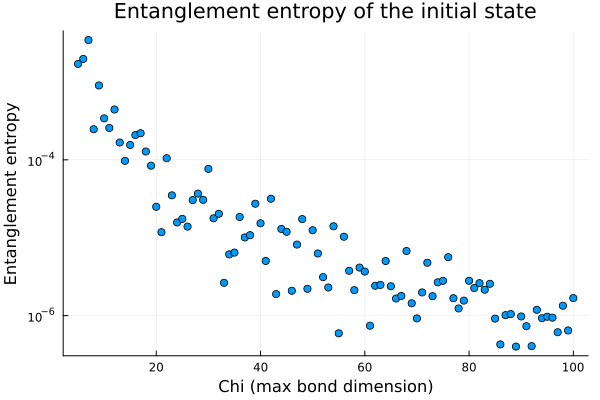

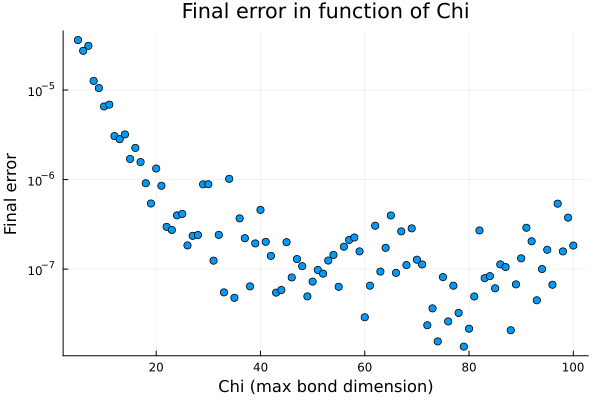

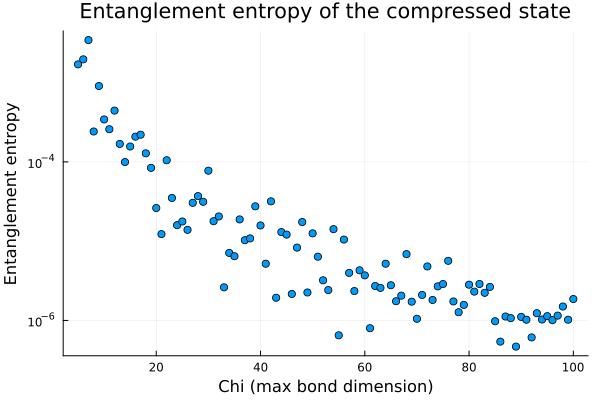

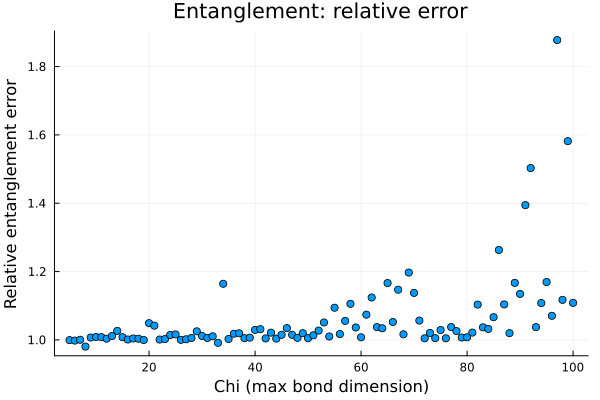

In [2]:
### Analysis of the amount of entanglement entropy inside of the initial state, compared with the compressed state

# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5
# random initializion
# CONTROL THE DMRG PARAMETERS?
# Create a DMRG algorithm instance
alg = DMRG(;  # Choose DMRG (1-site) for this example
    maxiter = 40,  # Maximum number of iterations
    verbose = false   # Verbosity level (0: silent, 1: basic, 2: detailed)
)


time_taken_function_of_chi_initial = []
fidelity_in_function_of_chi_initial = []
initial_entropy_in_function_of_chi_initial = []
compressed_entropy_in_function_of_chi_initial = []

chi_initial_list = collect(5:100)
L = 30

for chi_initial in chi_initial_list

    physical_index = ℝ^3
    max_virtualspace_exact = ℝ^chi_initial
    max_virtualspace_approx = ℝ^3

    Ψ_exact = FiniteMPS(                                                        # Generate a random initial state with large bond dimension
        rand, 
        Float64, 
        L, 
        physical_index, 
        max_virtualspace_exact)


    S_exact =  sum(real, entropy(Ψ_exact, Int((L/2))))
    push!(initial_entropy_in_function_of_chi_initial, S_exact)

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        max_virtualspace_approx)


    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    S_new = sum(real, entropy(Ψ_new, Int((L/2))))
    push!(compressed_entropy_in_function_of_chi_initial, S_new)

    push!(time_taken_function_of_chi_initial, time_taken)
    error = abs(1-dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))
    push!(fidelity_in_function_of_chi_initial, error)
    #display(entanglementplot(Ψ_new, L/2))
end



rel = compressed_entropy_in_function_of_chi_initial ./ initial_entropy_in_function_of_chi_initial
relative_entanglement_error = abs.(rel)
# Plot the results in function of L
display(scatter(chi_initial_list, initial_entropy_in_function_of_chi_initial, xlabel="Chi (max bond dimension)", ylabel="Entanglement entropy", title="Entanglement entropy of the initial state", legend=false, yscale=:log10))
display(scatter(chi_initial_list, fidelity_in_function_of_chi_initial, xlabel="Chi (max bond dimension)", ylabel="Final error", title="Final error in function of Chi", legend=false, yscale=:log10))
display(scatter(chi_initial_list, compressed_entropy_in_function_of_chi_initial, xlabel="Chi (max bond dimension)", ylabel="Entanglement entropy", title="Entanglement entropy of the compressed state", legend=false, yscale=:log10))
display(scatter(chi_initial_list, relative_entanglement_error, xlabel="Chi (max bond dimension)", ylabel="Relative entanglement error", title="Entanglement: relative error", legend=false))





Entanglement entropy in een random FiniteMPS in functie van de bond dimensie. \
Dit voor verschillende waarden van de lengte van de chain.
Use random matrix theory to explain this result?

In [3]:
# Statistical Analysis of how the entanglement entropy depends on the random state parameters
using Statistics
L_list = [35, 40, 45, 50, 55, 60, 65]

#L_list = [35, 40, 45, 50]

entropies = []

ph_dim = 3
for L in L_list 
    entropy_ifv_chi = []

    max_chi = Int(ph_dim*floor(L/2))
    chi_initial_list = collect(ph_dim:max_chi)

    for chi_initial in chi_initial_list

        physical_index = ℝ^ph_dim
        max_virtualspace_exact = ℝ^chi_initial
        max_virtualspace_approx = ℝ^3

        Ψ_exact = FiniteMPS(                                                        # Generate a random initial state with large bond dimension
            rand, 
            Float64, 
            L, 
            physical_index, 
            max_virtualspace_exact)


        S_exact = sum(real, entropy(Ψ_exact, Int(round(L/2))))
        push!(entropy_ifv_chi, S_exact)
    end
    push!(entropies, entropy_ifv_chi)
end


chi_initial_list = collect(ph_dim:length(entropies[end]))
correct_length_for_stats = []
printing = false
for (j, entropy) in enumerate(entropies)
    l = L_list[j]
    push!(correct_length_for_stats, entropy[1:48])
    if printing == true
        if j < length(entropies)
            display(scatter(chi_initial_list[1:length(entropy)], entropy, xlabel="D (max bond dimension)", ylabel="Entanglement entropy @ central site", title="Entanglement entropy: Random FiniteMPS, \n length = $l   , physical dim = $ph_dim", legend=false, yscale=:log10))
        else
            display(scatter(chi_initial_list, entropy, xlabel="D (max bond dimension)", ylabel="Entanglement entropy @ central site", title="Entanglement entropy: Random FiniteMPS, \n length = $l   , physical dim = $ph_dim", legend=false, yscale=:log10))
        end
    end
end

# perform a statistical analysis on correct_length_for_stats

mean_entanglement_entropy = mean(correct_length_for_stats)  # Reduce along the first dimension (columns)
std_entanglement_entropy = std(correct_length_for_stats)
# min_error_val = 1e-4
# std_entanglement_entropy = max.(std_entanglement_entropy, min_error_val)

# Error bars for y-axis with positive and negative standard deviations
scatter(collect(3:50), mean_entanglement_entropy, yerr=std_entanglement_entropy,
     marker=:circle, label=" Mean Entanglement Entropy", legend=:topright, yscale=:log10)
xlabel!("Maximal bond dimension D")
ylabel!("Entanglement entropy")
title!("Entanglement entropy in random FiniteMPS \n with different lengths")
ylims!(1e-7, 1e-1)  # Example ylims




#savefig(scatter(chi_initial_list, initial_entropy_in_function_of_chi_initial, xlabel="D (max bond dimension)", ylabel="Entanglement entropy @ central site", title="Entanglement entropy: Random FiniteMPS, \n length = $L, physical dim = $ph_dim", legend=false, yscale=:log10), "length_$L.png")

savefig("entanglement_entropy.png")  # Saves as PNG


"/home/bart/Desktop/Masterproef /Julia codes/Notebooks with initial implementations/entanglement_entropy.png"